# MTH 651: Advanced Numerical Analysis

## Lecture 11

### Topics

* Solving PDEs with MFEM

We saw how to use MFEM to perform $L^2$ projection using the variational formulation.

Now, let's use the same concepts to solve a PDE.
The equation of iterest is (as usual), the Poisson problem with Dirichlet boundary conditions

$$
    \begin{aligned}
        -\Delta u &= f \qquad \text{in $\Omega$}\\
        u &= 0 \qquad \text{on $\partial\Omega$}
    \end{aligned}
$$

This corresponds to the variational problem: $find $u_h \in V_h$ such that
$$
    \int_\Omega \nabla u_h \cdot \nabla v_h \,dx = \int_\Omega f v_h \, dx
$$
for all test functions $v_h \in V_h$, where $V_h$ is a finite element space,
$$
    V_h = \{ v_h \in \mathring{H}^1(\Omega) : v_h|K \in \mathcal{P}(K) \},
$$
where $\mathring{H}^1(\Omega)$ indicates that the functions $v_h$ have zero trace on $\partial\Omega$, i.e. they satisfy the homogeneous Dirichlet boundary conditions.
(In other words, the BCs are **built in** to the space, these are sometimes called **essential** boundary conditions).

The bilinear form $a(\cdot, \cdot) = (\nabla \cdot, \nabla \cdot)$ induces an **associated system matrix**.

Let $\phi_i$ denote the global basis functions.

Define the **stiffness matrix**

$$
    A_{ij} = a(\phi_i, \phi_j)
$$

Define the vector $F$ by

$$
    F_i = (f, v_i)
$$

Then, the variational problem is equation to the following linear system of equations

$$
    A U = F
$$

where the vector $U$ represents the coefficients of $u_h$ expanded in the basis $\phi_i$.

In [1]:
import mfem.ser as mfem
from glvis import glvis

In [2]:
# Create the mesh and finite element space
mesh = mfem.Mesh(20, 20, "TRIANGLE")
order_k = 1
fe_collection = mfem.H1_FECollection(order_k, mesh.Dimension())
fe_space = mfem.FiniteElementSpace(mesh, fe_collection)

# 5. Define the solution x as a finite element grid function in fespace. Set
#    the initial guess to zero, which also sets the boundary conditions.
u = mfem.GridFunction(fe_space)

# Create the right-hand side vector using the linear form F : v -> (f, v)
# This is called a "domain linear form integrator", or DomainLFIntegrator
# We just use the right-hand side 1
f = mfem.LinearForm(fe_space)
f.AddDomainIntegrator(mfem.DomainLFIntegrator(mfem.ConstantCoefficient(1.0)))
# F.Assemble() tells MFEM to actually compute the entries of the vector F
f.Assemble()

boundary_dofs = mfem.intArray()
fe_space.GetBoundaryTrueDofs(boundary_dofs)

# Set up the bilinear form a(.,.). The grad-grad bilinear form is called a
# "diffusion integrator"
a = mfem.BilinearForm(fe_space)
a.AddDomainIntegrator(mfem.DiffusionIntegrator())
a.Assemble()
a.Finalize()

A = mfem.SparseMatrix()
F = mfem.Vector()
U = mfem.Vector()
a.FormLinearSystem(boundary_dofs, u, f, A, U, F)


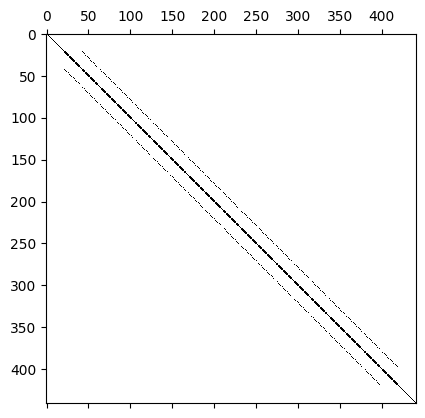

In [3]:
from mfem.common.sparse_utils import sparsemat_to_scipycsr
import matplotlib.pyplot as plt

plt.spy(sparsemat_to_scipycsr(A, float).todense())

In [4]:
Linv = mfem.GSSmoother(A)
GS = mfem.SLISolver()
GS.SetPreconditioner(Linv)
GS.SetOperator(A)
GS.SetRelTol(1e-10)
GS.SetMaxIter(1000)
GS.SetPrintLevel(1)
U.Assign(0.0)
GS.Mult(F,U)

   Iteration :   0  ||Br|| = 0.0436481
   Iteration :   1  ||Br|| = 0.0396346  	Conv. rate: 0.0396346
   Iteration :   2  ||Br|| = 0.0368988  	Conv. rate: 0.930973
   Iteration :   3  ||Br|| = 0.0346565  	Conv. rate: 0.939232
   Iteration :   4  ||Br|| = 0.0327074  	Conv. rate: 0.943759
   Iteration :   5  ||Br|| = 0.0309597  	Conv. rate: 0.946566
   Iteration :   6  ||Br|| = 0.0293624  	Conv. rate: 0.948409
   Iteration :   7  ||Br|| = 0.0278841  	Conv. rate: 0.949654
   Iteration :   8  ||Br|| = 0.0265041  	Conv. rate: 0.950507
   Iteration :   9  ||Br|| = 0.025208   	Conv. rate: 0.951097
   Iteration :  10  ||Br|| = 0.0239856  	Conv. rate: 0.951507
   Iteration :  11  ||Br|| = 0.0228293  	Conv. rate: 0.951792
   Iteration :  12  ||Br|| = 0.0217332  	Conv. rate: 0.95199
   Iteration :  13  ||Br|| = 0.0206928  	Conv. rate: 0.952129
   Iteration :  14  ||Br|| = 0.0197042  	Conv. rate: 0.952226
   Iteration :  15  ||Br|| = 0.0187642  	Conv. rate: 0.952293
   Iteration :  16  ||Br|| = 0.

We can see that Gauss-Seidel is very slow to converge.
Better methods (like conjugate gradient) are much faster.

In [5]:
GS = mfem.GSSmoother(A)
U.Assign(0.0)
mfem.PCG(A, GS, F, U, 1, 200, 1e-12, 0.0)

   Iteration : 0    (B r, r) = 0.00205533
   Iteration : 1    (B r, r) = 0.00389253
   Iteration : 2    (B r, r) = 0.00185828
   Iteration : 3    (B r, r) = 0.000734173
   Iteration : 4    (B r, r) = 0.000192014
   Iteration : 5    (B r, r) = 2.33778e-05
   Iteration : 6    (B r, r) = 1.35936e-06
   Iteration : 7    (B r, r) = 1.77269e-07
   Iteration : 8    (B r, r) = 3.15376e-08
   Iteration : 9    (B r, r) = 6.86801e-09
   Iteration : 10   (B r, r) = 1.95374e-09
   Iteration : 11   (B r, r) = 2.10326e-10
   Iteration : 12   (B r, r) = 6.9983e-12
   Iteration : 13   (B r, r) = 5.47487e-13
   Iteration : 14   (B r, r) = 3.69998e-13
   Iteration : 15   (B r, r) = 1.3335e-13
   Iteration : 16   (B r, r) = 1.11149e-14
   Iteration : 17   (B r, r) = 4.45622e-16
Average reduction factor = 0.424162


In [6]:
a.RecoverFEMSolution(U, f, u)
glvis((mesh, u))

glvis(data_str='MFEM mesh v1.0\n\n#\n# MFEM Geometry Types (see mesh/geom.hpp):\n#\n# POINT       = 0\n# SEGME…

In [7]:
from urllib.request import urlopen
def make_tmp_mesh_from_url(url):
    mesh_data = urlopen(url).read()
    mesh_f = open("tmp.mesh", "w")
    mesh_f.write(mesh_data.decode())
    mesh_f.close()

# make_tmp_mesh_from_url("https://github.com/pazner/mth-651/raw/main/data/meshes/dolphin.mesh")
make_tmp_mesh_from_url("https://github.com/pazner/mth-651/raw/main/data/meshes/square-disc.mesh")

mesh = mfem.Mesh("tmp.mesh")
order_k = 2
fe_collection = mfem.H1_FECollection(order_k, mesh.Dimension())
fe_space = mfem.FiniteElementSpace(mesh, fe_collection)
u = mfem.GridFunction(fe_space)
u.Assign(0.0)

one = mfem.ConstantCoefficient(1.0)
f = mfem.LinearForm(fe_space)
f.AddDomainIntegrator(mfem.DomainLFIntegrator(one))
f.Assemble()

boundary_dofs = mfem.intArray()
fe_space.GetBoundaryTrueDofs(boundary_dofs)

a = mfem.BilinearForm(fe_space)
a.AddDomainIntegrator(mfem.DiffusionIntegrator())
a.Assemble()
a.Finalize()

A = mfem.SparseMatrix()
F = mfem.Vector()
U = mfem.Vector()
a.FormLinearSystem(boundary_dofs, u, f, A, U, F)

GS = mfem.GSSmoother(A)
U.Assign(0.0)
mfem.PCG(A, GS, F, U, 1, 200, 1e-12, 0.0)

a.RecoverFEMSolution(U, f, u)
glvis((mesh, u))

   Iteration : 0    (B r, r) = 0.00159949
   Iteration : 1    (B r, r) = 0.00111617
   Iteration : 2    (B r, r) = 0.000508199
   Iteration : 3    (B r, r) = 0.000126007
   Iteration : 4    (B r, r) = 1.41445e-05
   Iteration : 5    (B r, r) = 1.1819e-06
   Iteration : 6    (B r, r) = 6.26271e-07
   Iteration : 7    (B r, r) = 1.23413e-07
   Iteration : 8    (B r, r) = 5.33027e-08
   Iteration : 9    (B r, r) = 1.50953e-08
   Iteration : 10   (B r, r) = 2.59336e-09
   Iteration : 11   (B r, r) = 4.51695e-10
   Iteration : 12   (B r, r) = 1.28208e-10
   Iteration : 13   (B r, r) = 1.50445e-11
   Iteration : 14   (B r, r) = 2.18557e-12
   Iteration : 15   (B r, r) = 3.52072e-13
   Iteration : 16   (B r, r) = 1.50548e-13
   Iteration : 17   (B r, r) = 5.92131e-14
   Iteration : 18   (B r, r) = 1.15206e-14
   Iteration : 19   (B r, r) = 1.66444e-15
   Iteration : 20   (B r, r) = 4.77945e-16
Average reduction factor = 0.486278


glvis(data_str='MFEM mesh v1.0\n\n#\n# MFEM Geometry Types (see mesh/geom.hpp):\n#\n# POINT       = 0\n# SEGME…

### Error estimates

The big question we want to answer now: can we prove error estimates?

How accurate is our numerical solution compared with the exact solution?

At what rate does the error go to zero as we perform $h$-refinement (for given polynomial degree $k$)?